**"I/we certify that the code and data in this assignment were generated independently, using only the tools and resources defined in the course and that I/we did not receive any external help, coaching or contributions during the production of this work."**



# A2C Implementation

## Import required libraries

In [ ]:
# install commonly required display helper libraries (optional if already installed)
!apt install ffmpeg xvfb python-opengl 
!pip3 install gym gym-notebook-wrapper box2d-py
!pip3 install gym[Box_2D] pygame pyvirtualdisplay
!pip3 install box2d box2d-kengz

In [ ]:
# import all the libraries
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F  # for access to activation functions
from torch.nn.modules.activation import ReLU
import torch.optim as optim
import matplotlib.pyplot as plt
import gnwrapper 
import math
import copy
from torch.distributions import Normal
from collections import deque
from IPython.display import clear_output
from pyvirtualdisplay import Display
_ = Display(size=(700, 700))
_.start()

Common class for storing constant values

In [ ]:
# Constants class for hyperparameter tuning
class Constants:
    EPISODE_COUNT = 100000
    ALPHA = 0.001
    ALPHA_ACTOR = 0.0001
    ALPHA_CRITIC = 0.001
    GAMMA = 0.89
    EPSILON = 1.0
    EPSILON_DECAY = 0.005
    EPSILON_MIN = 0.1
    EPSILON_MAX = 1.0
    BATCH_SIZE = 128
    TRAIN_START = 1000
    MEMORY_SIZE = 10000
    TARGET_UPDATE = 50
    PLOT_INTERVAL = 100
    MAX_MEMORY_SIZE = 10000
    SEED_VAL = 777
    NN_DIM = 128
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    LOG_DEBUG = False
    VANILLA_DQN = False
    WEIGHT_DIST = 0.003
    WEIGHT_ENTROPY = 0.01
    ENV_PENDULUM = 'Pendulum-v0'
    ENV_CARTPOLE = 'CartPole-v1'
    ENV_MOUNTAIN_CAR = 'MountainCar-v0'
    ENV_LUNAR_LANDER = 'LunarLanderContinuous-v2'
    ENV_BIPEDAL = 'BipedalWalker-v3'
    ENV_BENCHMARK = {'Pendulum-v0': -180, 'CartPole-v1': 470,  'MountainCar-v0': 0.59, 'LunarLanderContinuous-v2': 200, 'BipedalWalker-v3': 200}

print('DEVICE USED:', Constants.DEVICE)

DEVICE USED: cuda:0


## Part 1

### Actor-Critic Model Definition

In [ ]:
class ActorNetwork(nn.Module):
  def __init__(self, actions, input_shape, output_shape):
    super(ActorNetwork, self).__init__()
    self.actions = actions
    self.layer1 = nn.Linear(input_shape, Constants.NN_DIM)  

    self.layer2 = nn.Linear(Constants.NN_DIM, output_shape)
    self.layer2.weight.data.uniform_(-Constants.WEIGHT_DIST, Constants.WEIGHT_DIST)
    self.layer2.bias.data.uniform_(-Constants.WEIGHT_DIST, Constants.WEIGHT_DIST)
    
    self.layer3 = nn.Linear(Constants.NN_DIM, output_shape)    
    self.layer3.weight.data.uniform_(-Constants.WEIGHT_DIST, Constants.WEIGHT_DIST)
    self.layer3.bias.data.uniform_(-Constants.WEIGHT_DIST, Constants.WEIGHT_DIST)
  
  def forward(self,x):
    f1 = F.relu(self.layer1(x))
    avg = self.actions * torch.tanh(self.layer2(f1))    
    # calculations for action selection
    log = F.softplus(self.layer3(f1))
    dev = torch.exp(log) # softplus for approximating ReLU 
    prob_dist = Normal(avg, dev)
    return prob_dist.sample(), prob_dist 

class CriticNetwork(nn.Module):
  def __init__(self, input_shape, output_shape):
    super(CriticNetwork, self).__init__()
    self.layer1 = nn.Linear(input_shape, Constants.NN_DIM)
    # self.layer1.weight.data.uniform_(-Constants.WEIGHT_DIST, Constants.WEIGHT_DIST)
    # self.layer1.bias.data.uniform_(-Constants.WEIGHT_DIST, Constants.WEIGHT_DIST)

    self.layer2 = nn.Linear(Constants.NN_DIM, 1)
    self.layer2.weight.data.uniform_(-Constants.WEIGHT_DIST, Constants.WEIGHT_DIST)
    self.layer2.bias.data.uniform_(-Constants.WEIGHT_DIST, Constants.WEIGHT_DIST)
  
  def forward(self, x):
    f = F.relu(self.layer1(x))
    return self.layer2(f)

### Agent Class 

In [ ]:
class A2C:
  def __init__(self, env_name):
    seed = Constants.SEED_VAL    
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    self.next_state = list()
    self.steps = 0
    self.env = env_name
    self.env.seed(seed)
    self.env_name_raw = self.env.unwrapped.spec.id
    self.mode_train = True
    self.observation_shape = env_name.observation_space.shape[0]
    self.action_shape = env_name.action_space.shape[0]
    self.actions = float(env_name.action_space.high[0])
    self.actor =  ActorNetwork(self.actions, self.observation_shape, self.action_shape).to(Constants.DEVICE)
    self.critic = CriticNetwork(self.observation_shape, self.action_shape).to(Constants.DEVICE)
    self.actor_optim = optim.Adam(self.actor.parameters(), lr=Constants.ALPHA_ACTOR)
    self.critic_optim = optim.Adam(self.critic.parameters(), lr=Constants.ALPHA_CRITIC)
  
  def __to_floatTensor(self, obj):
    return torch.FloatTensor(obj).to(Constants.DEVICE)
  
  def _to_tensor(self, type, obj):
    if type == 'float': return self.__to_floatTensor(obj)
  
  def get_action(self, state):    
    state = self._to_tensor('float', state)
    action, prob_dist = self.actor(state)    
    next_action = action

    if not self.mode_train:
      next_action = prob_dist.mean
    else:
      log_prob = prob_dist.log_prob(next_action).sum(dim=-1)
      self.next_state = [state, log_prob]
    rangedAction = next_action.clamp(-2.0,2.0).cpu().detach().numpy() if self.env_name_raw == Constants.ENV_PENDULUM else next_action.cpu().detach().numpy()
    return rangedAction
  
  def step(self, action):
    observation, reward, done, info = self.env.step(action)
    if self.mode_train: self.next_state.extend([observation, reward, done, info])
    return observation, reward, done, info
  
  def _update_actor(self, loss):
    self.actor_optim.zero_grad()
    loss.backward()
    self.actor_optim.step()

  def _update_critic(self, loss):
    self.critic_optim.zero_grad()
    loss.backward()
    self.critic_optim.step()
  
  def _get_policy_loss(self, advantage, log_prob):    
    loss_policy = log_prob * -advantage
    loss_policy += -log_prob * Constants.WEIGHT_ENTROPY
    return loss_policy

  def update(self):
    state, log_prob, observation, reward, done, info = self.next_state
    observation = self._to_tensor('float', observation)
    val_pred = self.critic(state)
    val_target = reward + (1-done) * Constants.GAMMA * self.critic(observation)
    loss = F.smooth_l1_loss(val_pred, val_target.detach())
    self._update_critic(loss)    
    loss_policy = self._get_policy_loss((val_target - val_pred).detach(), log_prob)
    self._update_actor(loss_policy)
    return loss_policy.item(), loss.item()
  
  def _plot_actor_loss(self, loss_actor):
    plt.figure(figsize=(10,5))
    plt.plot(loss_actor, color='lightcoral', linewidth=3)
    plt.xlabel('Episodes', fontsize=17)
    plt.ylabel('Loss per episode', fontsize=17)
    plt.title('Actor Loss', fontsize=21)
    plt.grid()
    plt.show()

  def _plot_rewards(self, scores):
    plt.figure(figsize=(10,5))
    plt.plot(scores, color='lightseagreen', linewidth=3)
    plt.xlabel('Episode Range', fontsize=17)
    plt.ylabel('Cumulative Score/Rewards', fontsize=17)
    plt.title(f'Cumulative Rewards - Score: {0 if not np.mean(scores[-10:]) else np.mean(scores[-10:])}', fontsize=21)
    plt.grid()
    plt.show()
  
  def _plot_critic_loss(self, loss_critic):
    plt.figure(figsize=(10,5))
    plt.plot(loss_critic, color='fuchsia', linewidth=3)
    plt.xlabel('Episodes', fontsize=17)
    plt.ylabel('Loss per episode', fontsize=17)
    plt.title('Critic Loss', fontsize=21)
    plt.grid()
    plt.show()

  def plot_progress(self, loss_actor, loss_critic, scores):    
    clear_output(True)
    self._plot_rewards(scores)
    self._plot_actor_loss(loss_actor)  
    self._plot_critic_loss(loss_critic)

  def train_model(self):
    self.mode_train = True
    loss_list_actor, loss_list_critic, score_list = [],[],[]
    state = self.env.reset()
    score = 0

    for self.steps in range(1, Constants.EPISODE_COUNT + 1):     
      action = self.get_action(state)
      observation, reward, done, info = self.step(action)
      loss_actor, loss_critic = self.update()
      loss_list_actor.append(loss_actor)
      loss_list_critic.append(loss_critic)
      state = observation
      score += reward
      mean_score = np.mean(score_list[-10:]) # mean score over last 10 episodes

      if self.steps % Constants.PLOT_INTERVAL == 0:   
        self.plot_progress(loss_list_actor, loss_list_critic, score_list)
        # self.env.render()

      if done:
        score_list.append(score)
        score = 0
        state = env.reset()

      if mean_score >= Constants.ENV_BENCHMARK[self.env_name_raw]:
        break   

    self.env.close()
  
  def evaluate(self):
    self.mode_train = False
    state = self.env.reset()
    done = False
    score = 0
    score_list = []
    step = 1
    while step<=10 :
      self.env.render()
      action = self.get_action(state)
      observation, reward, done, info = self.step(action)
      state = observation
      score += reward
      score_list.append(score)
      step += 1
    self._plot_rewards(score_list)            
    # print('Score: ', score)
    self.env.close()   

## Training and Evaluation

**Training for Pendulum Environment**

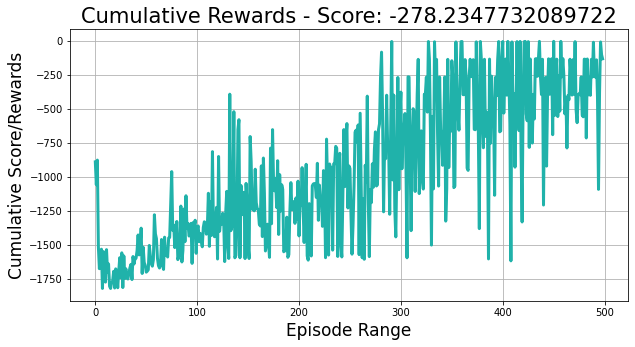

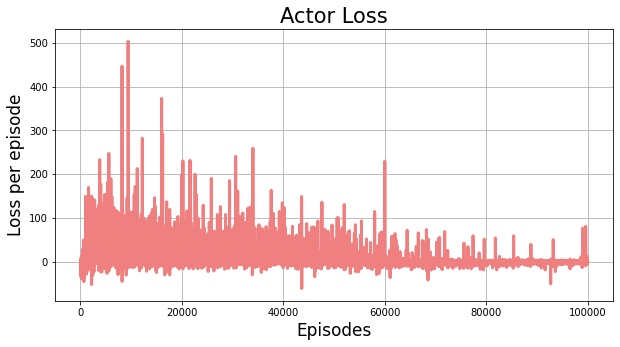

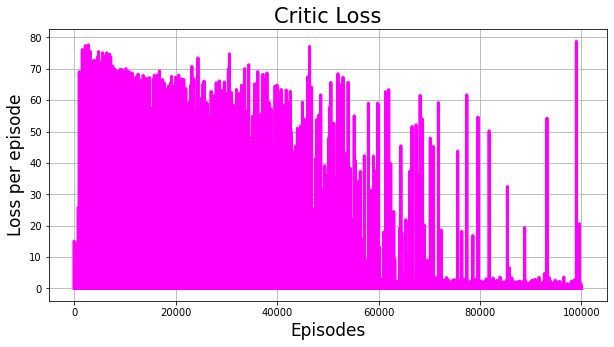

In [ ]:
env = gnwrapper.Animation(gym.make(Constants.ENV_PENDULUM))
agent = A2C(env)
agent.train_model()

## Evaluating the model

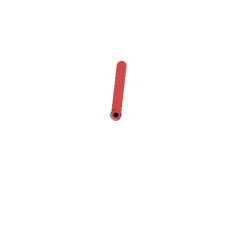

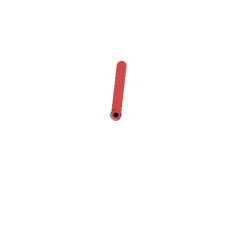

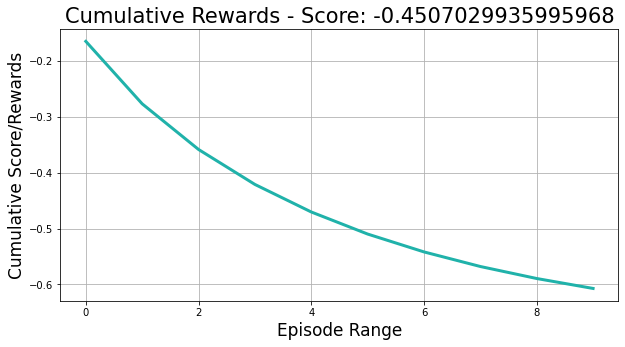

In [ ]:
agent.evaluate()

## Part 2

## Other Complex Environments

### Running Lunar Lander on A2C

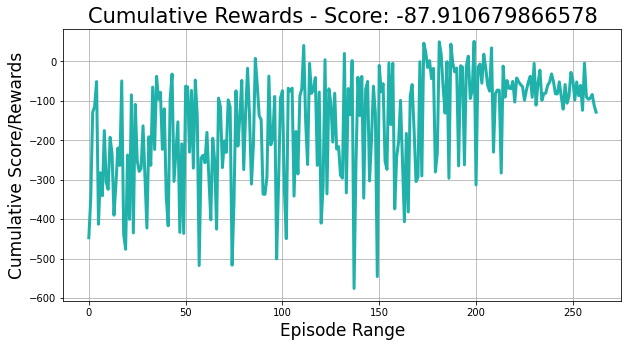

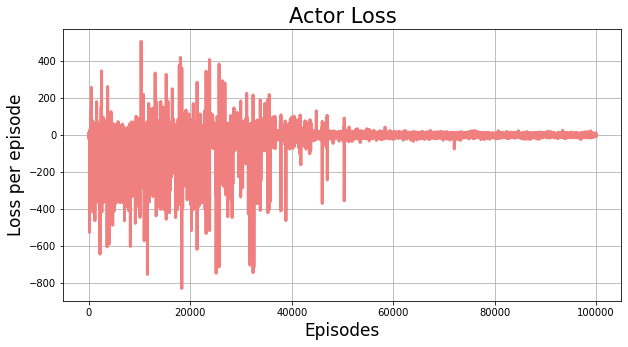

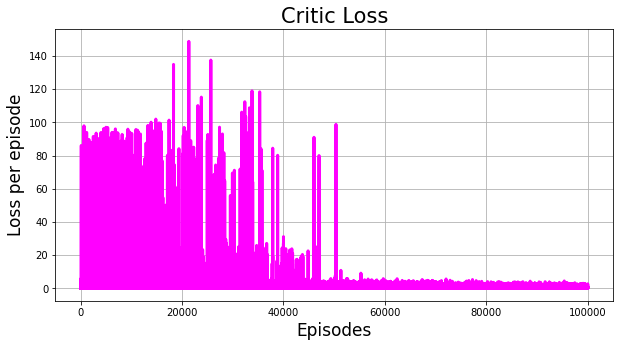

In [ ]:
# training lunar lander on a2c
env = gnwrapper.Animation(gym.make(Constants.ENV_LUNAR_LANDER))
agent = A2C(env)
agent.train_model()

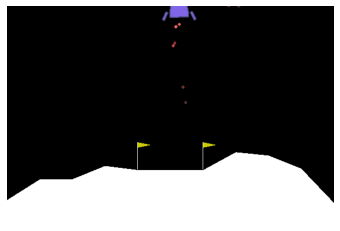

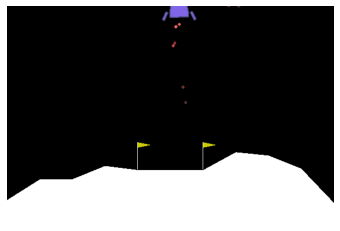

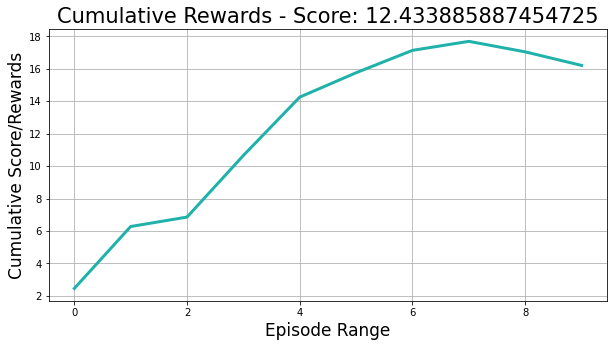

In [ ]:
# evaluating lunar lander on a2c
agent.evaluate()

### Running Bipedal Walker on base A2C

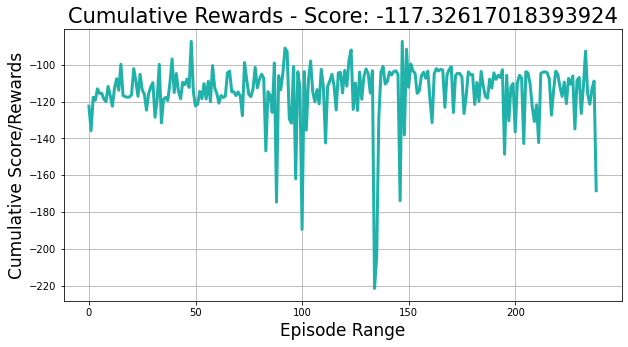

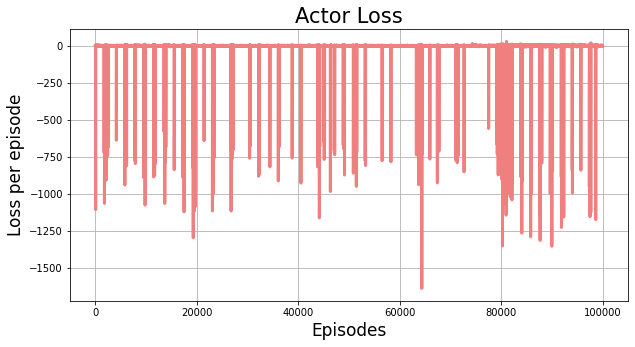

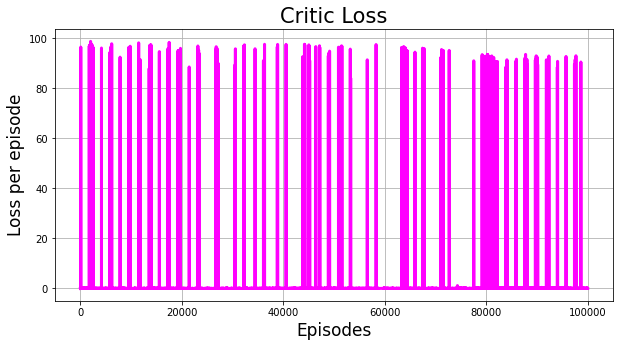

In [ ]:
# training the bipedal walker on a2c
env = gnwrapper.Animation(gym.make(Constants.ENV_BIPEDAL))
agent = A2C(env)
agent.train_model()

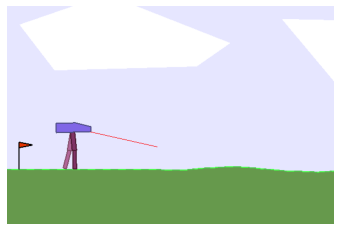

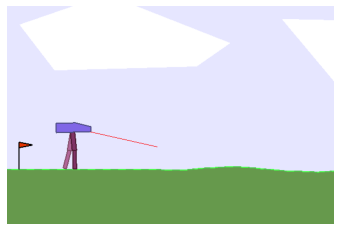

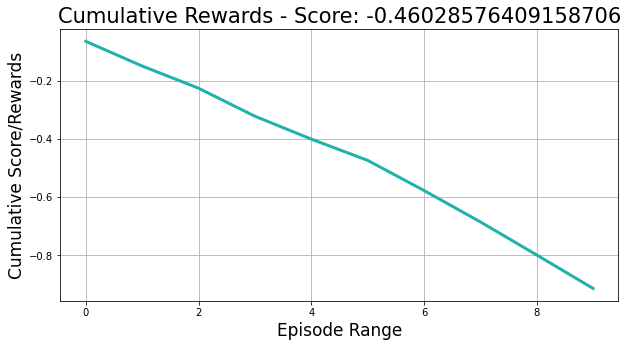

In [ ]:
# evaluating bipedal walker on a2c
agent.evaluate()

# TD3 Implementation

## Class Definitions

### Class for storing hyperparameter details

In [51]:
# Re-Defining the Constants class for hyper-parameters required for TD3
class Constants:
    EPISODE_COUNT = 350
    ALPHA = 0.0001
    ALPHA_ACTOR = 0.0001
    ALPHA_CRITIC = 0.001
    GAMMA = 0.89
    TAU = 0.005
    EPSILON = 0.1
    EPSILON_DECAY = 0.005
    EPSILON_MIN = 0.1
    EPSILON_MAX = 1.0
    BATCH_SIZE = 256
    TRAIN_START = 1000
    MEMORY_SIZE = 10000
    TARGET_UPDATE = 2
    PLOT_INTERVAL = 100
    MAX_MEMORY_SIZE = 1000000
    SEED_VAL = 1
    NN_DIM = 128
    NN_DIM2 = 128
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    LOG_DEBUG = False
    VANILLA_DQN = False
    WEIGHT_DIST = 3e-3
    WEIGHT_ENTROPY = 1e-2
    NOISE = 0.1
    NOISE_DIST = 0.2
    TIMESTEPS = 2000
    ENV_PENDULUM = 'Pendulum-v0'
    ENV_CARTPOLE = 'CartPole-v1'
    ENV_MOUNTAIN_CAR = 'MountainCar-v0'
    ENV_LUNAR_LANDER = 'LunarLanderContinuous-v2'
    ENV_BIPEDAL = 'BipedalWalker-v3'
    ENV_BENCHMARK = {'Pendulum-v0': -180, 'CartPole-v1': 470,  'MountainCar-v0': 0.59, 'LunarLanderContinuous-v2': 200, 'BipedalWalker-v3': 200}

print('DEVICE USED:', Constants.DEVICE)

DEVICE USED: cuda:0


### Actor Critic Model Definition

In [52]:
class ActorModel(nn.Module):
  def __init__(self, actions, input_shape, output_shape):
    super(ActorModel, self).__init__()
    self.env_actions = actions
    self.layer1 = nn.Linear(input_shape, Constants.NN_DIM)
    self.layer2 = nn.Linear(Constants.NN_DIM, Constants.NN_DIM2)
    self.layer3 = nn.Linear(Constants.NN_DIM2, output_shape)
  
  def forward(self, x):
    # print('Forward: ', x.shape)
    f = F.relu(self.layer1(x))
    f = F.relu(self.layer2(f))
    f = torch.tanh(self.layer3(f)) * self.env_actions
    return f
  
class CriticModel(nn.Module):
  def __init__(self, input_shape, output_shape):
    super(CriticModel, self).__init__()
    input_dim = input_shape + output_shape
    self.layer1 = nn.Linear(input_dim, Constants.NN_DIM)
    self.layer2 = nn.Linear(Constants.NN_DIM, Constants.NN_DIM2)
    self.layer3 = nn.Linear(Constants.NN_DIM2, 1)
    self.layer4 = nn.Linear(input_dim, Constants.NN_DIM)
    self.layer5 = nn.Linear(Constants.NN_DIM, Constants.NN_DIM2)
    self.layer6 = nn.Linear(Constants.NN_DIM2, 1)
  
  def forward(self, x, a):
    # returns twin Q functions for comparison
    f = F.relu(self.layer1(torch.cat([x,a], 1)))
    f = F.relu(self.layer2(f))
    f = self.layer3(f)
    f1 = F.relu(self.layer4(torch.cat([x,a], 1)))
    f1 = F.relu(self.layer5(f1))
    f1 = self.layer6(f1)
    # use smaller of the two 
    return (f,f1)


### Agent Class Definition

In [55]:
from torch.cuda.random import seed
class TD3:
  def __init__(self, env_name):
    seed = Constants.SEED_VAL
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    self.env = env_name
    self.env.seed(seed)
    self.env_name_raw = self.env.unwrapped.spec.id
    self.mode_train = True
    self.observation_shape = env_name.observation_space.shape[0]
    self.action_shape = env_name.action_space.shape[0]
    self.actions = float(env_name.action_space.high[0])
    # print('observation: ', self.observation_shape, ' actions: ', self.action_shape)
    self.actor = ActorModel(self.actions, self.observation_shape, self.action_shape).to(Constants.DEVICE)
    self.target_actor = copy.deepcopy(self.actor)
    self.target_actor.load_state_dict(self.actor.state_dict())
    self.critic = CriticModel(self.observation_shape, self.action_shape).to(Constants.DEVICE)
    self.target_critic = copy.deepcopy(self.critic)
    self.target_critic.load_state_dict(self.critic.state_dict())
    self.optim_actor = torch.optim.Adam(self.actor.parameters(), lr=Constants.ALPHA_ACTOR)
    self.optim_critic = torch.optim.Adam(self.critic.parameters(), lr=Constants.ALPHA_CRITIC)
    self.buffer = deque(maxlen=Constants.MAX_MEMORY_SIZE)
    self.buffer_ptr = 0
  
  def remember(self, s, a, r, o, d):
    if self.buffer_ptr > self.buffer.maxlen:
      self.buffer[self.buffer_ptr] = (s,a,r,o,d)
      self.buffer_ptr = (self.buffer_ptr + 1) % self.buffer.maxlen
    else:
      self.buffer.append((s, a, r, o, d))
  
  def _to_tensor(self,batch):
    s, a, r, o, d = zip(*batch)
    s , a =   torch.from_numpy(np.array(s, dtype=np.float32)).to(Constants.DEVICE),\
              torch.from_numpy(np.array(a, dtype=np.float32)).to(Constants.DEVICE)
    o, r, d = torch.from_numpy(np.array(o, dtype=np.float32)).to(Constants.DEVICE),\
              torch.from_numpy(np.array(r, dtype=np.float32).reshape(-1,1)).to(Constants.DEVICE),\
              torch.from_numpy(np.array(d, dtype=np.uint8).reshape(-1,1)).float().to(Constants.DEVICE)
    return (s, a, r, o, d)

  
  def get_random_batch(self):
    batch = random.sample(self.buffer, Constants.BATCH_SIZE)
    random_batch = self._to_tensor(batch)
    return random_batch
  
  def _to_float_tensor(self, obj):
    return torch.FloatTensor(obj).to(Constants.DEVICE)

  def get_action(self, state):
    state_reshape = self._to_float_tensor(state)
    # print('Reshaped state: ', state_reshape.shape)
    state = state_reshape
    action = self.actor(state).cpu().data.numpy().flatten()
    action += (np.random.normal(0, Constants.NOISE, size=self.action_shape))
    return self.actor(state).cpu().data.numpy().flatten()
  
  def _update_critic(self, loss):
    self.optim_critic.zero_grad()
    loss.backward()
    self.optim_critic.step()
  
  def _update_actor(self, loss):
    self.optim_actor.zero_grad()
    loss.backward()
    self.optim_actor.step()

  def _update_actor_params(self):
    for p, t in zip(self.actor.parameters(), self.target_actor.parameters()):
      t.data.copy_(Constants.TAU * p.data + (1 - Constants.TAU) * t.data)
  
  def _update_critic_params(self):
    for p, t in zip(self.critic.parameters(), self.target_critic.parameters()):
      t.data.copy_(Constants.TAU * p.data + (1 - Constants.TAU) * t.data)
  
  def update_model(self, itr):
    s, a, r, o, d = self.get_random_batch()
    add_noise = a.clone().detach().normal_(0, Constants.NOISE_DIST).clamp(-Constants.NOISE_DIST, Constants.NOISE_DIST)
    new_action = (self.target_actor(o) + add_noise).clamp(-self.actions, self.actions)
    t_q1, t_q2 = self.target_critic(o, new_action)
    q = (r + (torch.min(t_q1,t_q2)) * (1-d) * Constants.GAMMA).to(Constants.DEVICE)
    c_q1, c_q2 = self.critic(s, a)
    c_loss = F.mse_loss(c_q1, t_q1) + F.mse_loss(c_q2, t_q2)
    self._update_critic(c_loss)
    if itr%Constants.TARGET_UPDATE == 0:
      a_loss = -self.critic(s, self.actor(s))[0]
      mean_a_loss = a_loss.mean()
      self._update_actor(mean_a_loss)
      self._update_actor_params()
      self._update_critic_params()
  
  def _plot_rewards(self, episode, scores):
    clear_output(True)
    plt.figure(figsize=(10,5))
    plt.plot(scores, color='lightseagreen' if self.mode_train else 'fuchsia', linewidth=3)
    plt.xlabel('Episodes', fontsize=17)
    plt.ylabel('Cumulative Score/Rewards', fontsize=17)
    plt.title(f'Episode: {episode} Score: {0 if not np.mean(scores[-10:]) else np.mean(scores[-10:])}', fontsize=21)
    plt.grid()
    plt.show()

  def train(self):
    self.mode_train = True
    score_list = []
    for episode in range(Constants.EPISODE_COUNT):
      state = self.env.reset()
      rewards = 0
      for timestep in range(Constants.TIMESTEPS):
        action = (self.get_action(state) + np.random.normal(0, self.actions * Constants.NOISE, size=self.action_shape)).clip(self.env.action_space.low, self.env.action_space.high)
        observation, reward, done, _ = self.env.step(action)
        self.remember(state, action, reward, observation, done)
        state = observation
        rewards += reward
        # env.render()
        if done:
          score_list.append(rewards)
          if Constants.LOG_DEBUG: 
            print(f'Episode: {episode} timestep: {timestep} Rewards: {rewards}')
          break
        if (len(self.buffer) > Constants.BATCH_SIZE):
          self.update_model(timestep)
      # plot graphs
      self._plot_rewards(episode, score_list)

      # early stopping
      if np.mean(score_list[-10:]) >= Constants.ENV_BENCHMARK[self.env_name_raw]:
        break
  
  def evaluate(self):
    done = False
    self.mode_train = False
    score_list = []
    state = self.env.reset()
    rewards = 0
    step = 0
    while step<=10:
      self.env.render()
      action = self.get_action(state)
      observation, reward, done, info = self.env.step(action)
      rewards+=reward
      score_list.append(rewards)
      self._plot_rewards(step, score_list)
      step += 1

## Training and Evaluation

### Running Pendulum on TD3

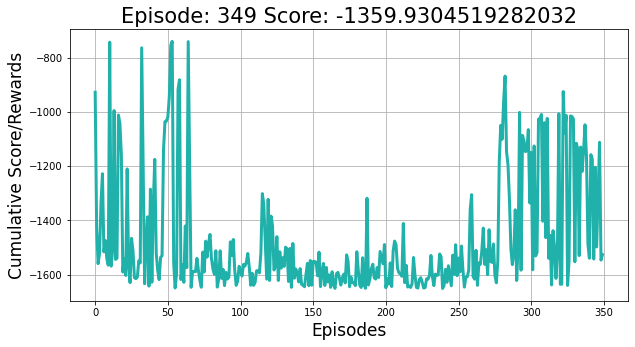

In [56]:
env = gym.make(Constants.ENV_PENDULUM)
agent = TD3(env)
agent.train()

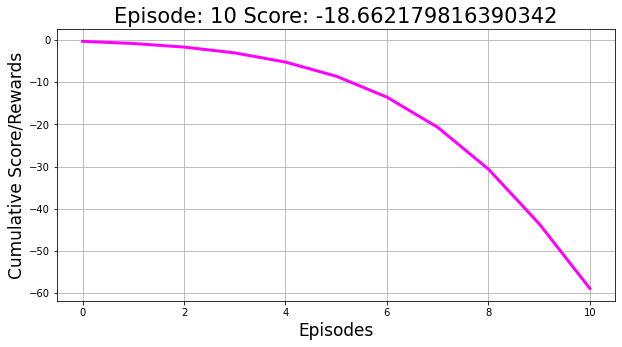

In [57]:
agent.evaluate()

### Running Lunar Lander on TD3

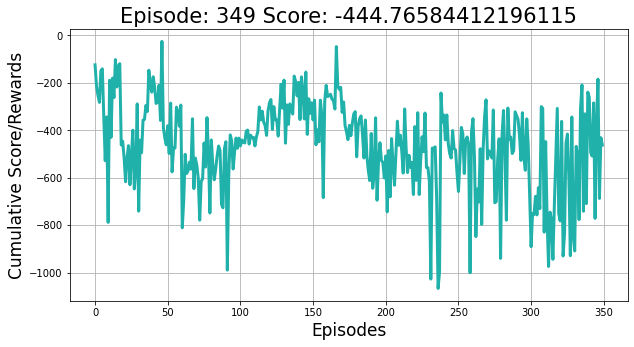

In [58]:
env = gym.make(Constants.ENV_LUNAR_LANDER)
agent = TD3(env)
agent.train()

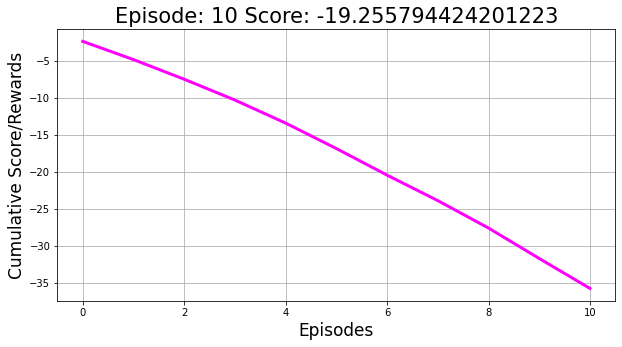

In [59]:
agent.evaluate()

### Running Bipedal Walker on TD3

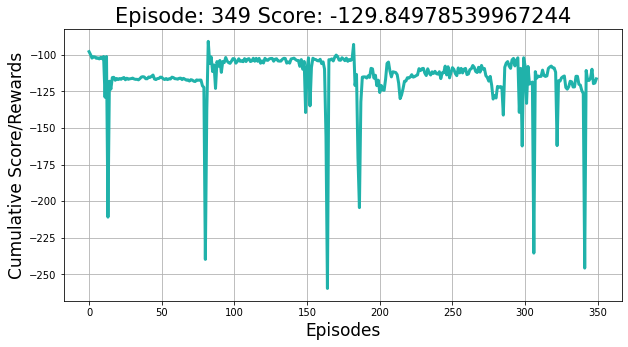

In [60]:
env = gym.make(Constants.ENV_BIPEDAL)
agent = TD3(env)
agent.train()

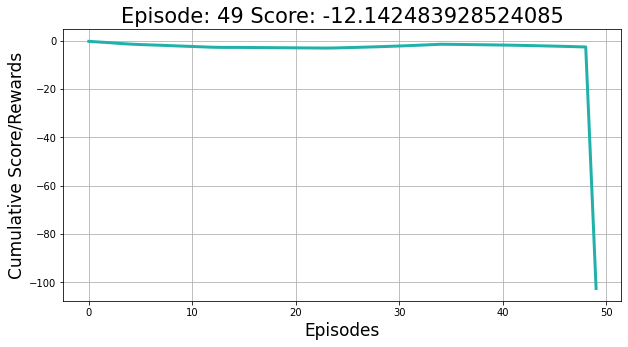

In [ ]:
agent.evaluate()